In [190]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import random
import seaborn as sns
sns.set(style="whitegrid")
import collections 

## Problem 1.1 - Epidemics over symmetric graphs

You should simulate an epidemic on a symmetric k-regular graph with 500 nodes and k = 4. Let $\beta=3$ and $\rho$=0.7.
With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

$\rho$ is the probability that at one time step an infected I individual recovers becoming state R (mutation kernel).

$\beta$ is the probability that a susceptible S becomes and infected I based on the number of infected neighbors.

In [184]:
def draw_k_symmetric(n=8,k=4):
    G = nx.Graph()
    for i in range(n-2):
        G.add_edge(i, i+1)
        G.add_edge(i, i+2)
    G.add_edge(n-2, n-1)
    G.add_edge(n-2, 0)
    G.add_edge(n-1, 0)
    G.add_edge(n-1, 1)
    
    #nx.draw_circular(G, with_labels = True)
    
    return G

G = draw_k_symmetric(500)
print(G)

Graph with 500 nodes and 1000 edges


In [20]:
print([i for i in G.neighbors(10)])

[8, 9, 11, 12]


$$\textbf{SIR:}\qquad\psi=\left[\begin{array}{ccc}1&0&0\\0&0&1\\0&0&1\end{array}\right]\qquad\varphi(S)=\varphi(R)=\left[\begin{array}{ccc}1&0&0\\0&1&0\\0&0&1\end{array}\right]\qquad\varphi(I)=\left[\begin{array}{ccc}0&1&0\\0&1&0\\0&0&1\end{array}\right]$$

In [182]:
# Number of agents, the number of nodes in the graph
n_agents = len(G)

beta = 0.3
rho = 0.7

# S=0, I=1, R=2

n_weeks = 15
n_simulation = 100

tot_susceptible = np.zeros(n_weeks, dtype=int)
tot_infected = np.zeros(n_weeks, dtype=int)
tot_recovered = np.zeros(n_weeks, dtype=int)
tot_new_infection = np.zeros(n_weeks, dtype=int)

for i in range(n_simulation):
    # Initial configuration with random 10 infected nodes
    status = np.zeros(n_agents, dtype=int)
    initial_contagion = random.sample(list(np.arange(n_agents)), 10)
    for ix in initial_contagion:
        status[ix] = 1

    susceptible = []
    infected = []
    recovered = []
    new_infection = []

    curr_state = status.copy()
    
    for week in range(n_weeks):
        prev_state = curr_state.copy()
        new_infect = 0      
        for node in range(n_agents):
            # If the node is susceptible
            if prev_state[node] == 0:
                # compute the number of infected neighbors
                neighbors = [i for i in G.neighbors(node)]
                infect = sum(list(filter(lambda k:k==1, prev_state[neighbors])))
                # compute the probability of infection
                prob_infection = 1 - (1-beta)**infect
                if np.random.rand() < prob_infection:
                    # infected!
                    curr_state[node] = 1
                    new_infect += 1
            # If the node is infected
            elif prev_state[node] == 1:
                # probability of recover is rho = 0.7
                if np.random.rand() < rho:
                    # recoved!
                    curr_state[node] = 2
        new_infection.append(new_infect)
        susceptible.append(len(np.argwhere(curr_state == 0)))
        infected.append(len(np.argwhere(curr_state == 1)))
        recovered.append(len(np.argwhere(curr_state == 2)))
    #print("susceptible:    ", susceptible)   
    #print("infected:       ", infected) 
    #print("susceptible:    ", recovered) 
    #print("new infections: ", new_infection) 
    
    tot_susceptible = [sum(s) for s in zip(tot_susceptible, susceptible)]
    tot_infected = [sum(s) for s in zip(tot_infected, infected)]
    tot_recovered = [sum(s) for s in zip(tot_recovered, recovered)]
    tot_new_infection = [sum(s) for s in zip(tot_new_infection, new_infection)]
    #print(tot_susceptible)
    #print()
    
avg_susceptible = [x/n_simulation for x in tot_susceptible]
avg_infected = [x/n_simulation for x in tot_infected]
avg_recovered = [x/n_simulation for x in tot_recovered]
avg_new_infection = [x/n_simulation for x in tot_new_infection]
print("avg susceptible:")
print(avg_susceptible)
print("avg infected:")
print(avg_infected)
print("avg recovered:")
print(avg_recovered)
print("avg new infection:")
print(avg_new_infection)

avg susceptible:
[478.26, 467.67, 459.93, 454.44, 450.16, 447.22, 444.98, 443.31, 442.13, 441.29, 440.67, 440.19, 439.87, 439.62, 439.4]
avg infected:
[14.83, 14.83, 12.39, 9.26, 7.15, 5.27, 3.79, 2.84, 2.03, 1.44, 1.04, 0.82, 0.61, 0.42, 0.35]
avg recovered:
[6.91, 17.5, 27.68, 36.3, 42.69, 47.51, 51.23, 53.85, 55.84, 57.27, 58.29, 58.99, 59.52, 59.96, 60.25]
avg new infection:
[11.74, 10.59, 7.74, 5.49, 4.28, 2.94, 2.24, 1.67, 1.18, 0.84, 0.62, 0.48, 0.32, 0.25, 0.22]


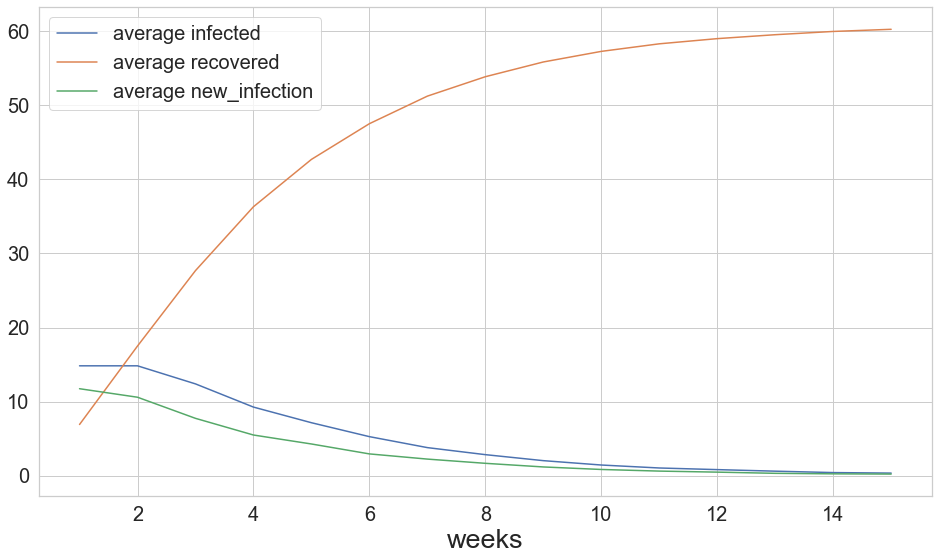

In [183]:
fig = plt.figure(1, figsize=(16,9))
x = list(np.arange(15)+1)

#plt.plot(x, avg_susceptible, label="average susceptible") 
plt.plot(x, avg_infected, label="average infected") 
plt.plot(x, avg_recovered, label="average recovered") 
plt.plot(x, avg_new_infection, label="average new_infection") 
plt.xlabel("weeks", fontsize = 27)
plt.xticks(size=20)
plt.yticks(size=20)


plt.legend(fontsize=20)

plt.show()

## Problem 1.2 - Preferential Attachment Random Graph

In [268]:
def create_random_graph(n=40, k=7):
    
    GPA = nx.complete_graph(k+1)
    
    for node in range(k+1, n):
        if k % 2 == 1:
            # if k is uneven take alternatively the floor and ceil of the number
            if node % 2 == 0:
                d = int(np.floor(k/2))
            else:
                d = int(np.ceil(k/2))
        else:
            # k is even
            d = int(k/2)
        
        deg_PA = [d for n, d in GPA.degree()]
        probabilities = np.array(deg_PA)/sum(deg_PA)
        #print(deg_PA)
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), p=probabilities, size=d, replace=False)
        GPA.add_node(node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(node,neigh)   

    nx.draw_circular(GPA, with_labels = True)
    deg_PA = [d for n, d in GPA.degree()]
    print()
    print("number of nodes: ", len(GPA))
    print("average degree: ", sum(deg_PA)/len(GPA))


number of nodes:  910
average degree:  7.0


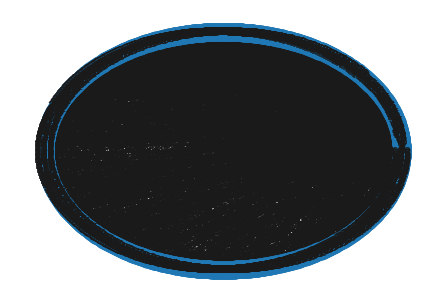

In [269]:
create_random_graph(910, 7)    

## Below trash

degree sequence:
[19, 15, 11, 10, 10, 9, 9, 9, 8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3]
degree:#nodes with that degree
Counter({5: 7, 4: 6, 6: 4, 9: 3, 10: 2, 8: 2, 7: 2, 19: 1, 15: 1, 11: 1, 3: 1})
degree and #nodes decoupled
(19, 15, 11, 10, 9, 8, 7, 6, 5, 4, 3)
(1, 1, 1, 2, 3, 2, 2, 4, 7, 6, 1)
probability based on the degree
[0.03333333 0.03333333 0.03333333 0.06666667 0.1        0.06666667
 0.06666667 0.13333333 0.23333333 0.2        0.03333333]


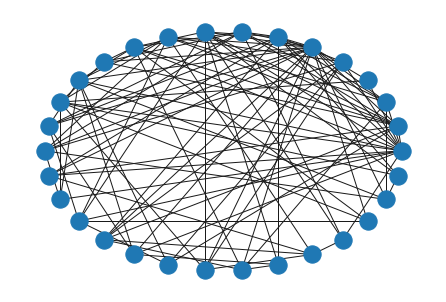

In [207]:
RG = nx.generators.random_graphs.barabasi_albert_graph(30, 4, 17)
nx.draw_circular(RG)
degree_sequence = sorted([d for n, d in RG.degree()], reverse=True) 
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
deg_distr = np.array(cnt)/sum(cnt) 
print("degree sequence:")
print(degree_sequence)
print("degree:#nodes with that degree")
print(degreeCount)
print("degree and #nodes decoupled")
print(deg)
print(cnt)
print("probability based on the degree")
print(deg_distr)

In [159]:
list(np.arange(15)+1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [53]:
np.random.rand()

0.8213854215570423

In [144]:
x = [10, 2,3]
y = [10, 2,3]
[sum(j) for j in zip(x, y)]

[20, 4, 6]

In [4]:
# Number of agents, the number of nodes in the graph
n_agents = len(G)

# S=0, I=1, R=2

# Mutation kernel
psi = np.array([[1,0,0],
                [0,0,1],
                [0,0,1]])

# Nodes activation rate rho
rho = 0.7

# Pairwise interaction kernels
# 3-dimensional array
phi = np.array([[[1,0,0],
                 [0,1,0],
                 [0,0,1]], 
                [[0,1,0],
                 [0,1,0],
                 [0,0,1]],
                [[1,0,0],
                 [0,1,0],
                 [0,0,1]]])

# Links activation rate beta
beta = 0.7

# Adjacency matrix, interactions are encoded in the graph.
W = nx.convert_matrix.to_numpy_matrix(G)

# Number of states for each agent
n_states = tuple(3 for _ in range(n_agents))

# Define the 2 probabilities:
# - the index=0 is the node activation
# - the index=1 is the link activation
node_link_activation = [1/(1+beta), 1-(1/(1+beta))]
node_link_activation_sum = np.cumsum(node_link_activation)

# Initialize the time
time = []
t_next = 0

# store the ids of visited configurations, describing the state of each agent
states = list()
# in the initial configuration, agent 0 is infected
x0 = np.zeros(n_agents, dtype=int)

# define initial state (time 0)
states.append(tuple(x0))
initial_contagion = random.sample(list(np.arange(n_agents)), 10)
for ix in initial_contagion:
    x0[ix] = 1
    
states[0] = x0 

i=1
for i in range(500*15):
#for i in range(1):    
    # consider the current configuration
    x = np.array(states[0])
    print(x)
    # define a list of admissible destination configurations, 
    # and the rates of the corresponding transitions
    destinations = list()
    transition_rates = list()    
    # admissible destinations differ from the current configuration
    # for the state of a single agent
    for agent in range(n_agents):
        # compute the neighbors of the other_agent in the graph
        neighbors = [i for i in G.neighbors(agent)]
        infected = sum(list(filter(lambda k:k==1, x[neighbors])))
        phi_xy = 1 - (1-beta)**infected
        # construct an admissible destination and append it to the list
        y = np.array(x)
        if y[agent] < 1:
            y[agent] = 1-y[agent]
        y_id = (y, agent, phi_xy)
        destinations.append(y_id)
        # compute the transition rate from x to y
        rate = 0
        for other_agent in range(n_agents):
            # for every other_agent in the network, 
            # compute its contribution to the rate of the transition of the agent
            rate += 1 + beta*W[agent,other_agent]*phi[x[other_agent], x[agent], y[agent]] 
        transition_rates.append(rate) 
    # given all transition rates from x to admissible y
    # compute w_x, the clock rate of configuration x
    # Notice: transition_rates is the x-th row of Lambda
    transition_rates = np.array(transition_rates)
    w_x = np.sum(transition_rates)
    # probabilities of transitioning to each admissible configuration y
    probabilities = transition_rates / w_x
    # next state is chosen at random from the possible destination 
    # with the probability distribution probabilities
    index_destin = np.arange(len(destinations))
    index_destin = np.random.choice(index_destin, p=probabilities)
       
    # With relative rates choosing between node or link activation
    node_link_activ = np.argwhere(node_link_activation_sum > np.random.rand())[0][0]
    
    if node_link_activ == 1:
        # if node_link_activ = 1 I have a link activation, so the
        # probability of get infected based on the infected neighbors
        prob_infection = [destinations[index_destin][2], 1-(destinations[index_destin][2])]
        prob_infection = np.cumsum(prob_infection)
        index = np.argwhere(prob_infection > np.random.rand())[0][0]
        if index == 0:
            states[0] = destinations[index_destin][0]
    
    if node_link_activ == 0:
        prob_infection = [rho, 1-rho]
        prob_infection = np.cumsum(prob_infection)
        index = np.argwhere(prob_infection > np.random.rand())[0][0]
        if index == 0:
            agent_index = destinations[index_destin][1]
            # if node_link_activ = 1 I have a node activation,
            # I retrieve the actual status of the node
            actual_status = x[agent_index]
            # I take the row of the mutation kernel and I seach 
            # the index containing the 1, the next status
            new_status = psi[actual_status,:].tolist().index(1)
            x[agent_index] = new_status
            states[0] = x
    
    print("time: ", i)
    print("#susceptible: ", len(np.argwhere(x == 0)))
    print("#infected: ", len(np.argwhere(x == 1)))
    print("#recovery: ", len(np.argwhere(x == 2)))
    i += 1

Output streaming troncato alle ultime 5000 righe.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0

KeyboardInterrupt: ignored